# Importing the Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid

# Preparing the Data

In [2]:
# Looking into the Directory
data_dir = 'dataset'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['validation', 'README', 'fer2013.bib', 'fer2013.csv', 'train']
Train Classes - ['Surprise', 'Fear', 'Angry', 'Neutral', 'Sad', 'Disgust', 'Happy']
Validation Classes - ['Surprise', 'Fear', 'Angry', 'Neutral', 'Sad', 'Disgust', 'Happy']


In [3]:
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
classes

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Data Augmentation

In [4]:
# Data Transforms (Gray Scaling & Data Augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [5]:
# Emotion Detection Datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/validation', valid_tfms)

## Classes Composition

In [6]:
print(f'There are:\n          {len(train_ds.targets)} images in the Train Data and\n          {len(valid_ds.targets)} images in the Validation Data')

There are:
          28709 images in the Train Data and
          3589 images in the Validation Data


In [7]:
pd.DataFrame({
    'Train': pd.Series(train_ds.targets).value_counts().sort_index().values,
    'Validation': pd.Series(valid_ds.targets).value_counts().sort_index().values
}, index=classes)

,Train,Validation
Angry,3995,491
Disgust,436,55
Fear,4097,528
Happy,7215,879
Neutral,4965,626
Sad,4830,594
Surprise,3171,416


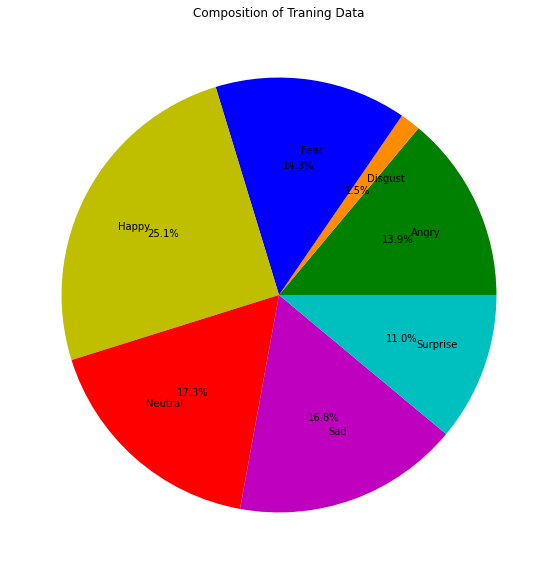

In [8]:
plt.subplots(figsize=(10,10))
plt.pie(pd.Series(train_ds.targets).value_counts().sort_index(), autopct='%0.1f%%', labels=classes, labeldistance=0.67, colors=['g','darkorange', 'b', 'y', 'r', 'm', 'c'])
plt.title('Composition of Traning Data')
plt.savefig('plots/train_composition.png', bboxes_inches='tight')
plt.show()

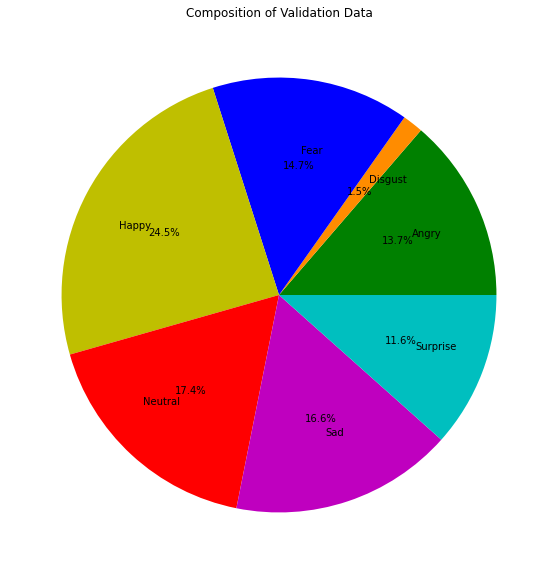

In [9]:
plt.subplots(figsize=(10,10))
plt.pie(pd.Series(valid_ds.targets).value_counts().sort_index(), autopct='%0.1f%%', labels=classes, labeldistance=0.67, colors=['g','darkorange', 'b', 'y', 'r', 'm', 'c'])
plt.title('Composition of Validation Data')
plt.savefig('plots/valid_composition.png', bboxes_inches='tight')
plt.show()

In [10]:
batch_size = 200

In [11]:
# PyTorch Data Loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        plt.savefig('plots/sample_batch.png', bboxes_inches='tight')
        break

torch.Size([1, 48, 48])


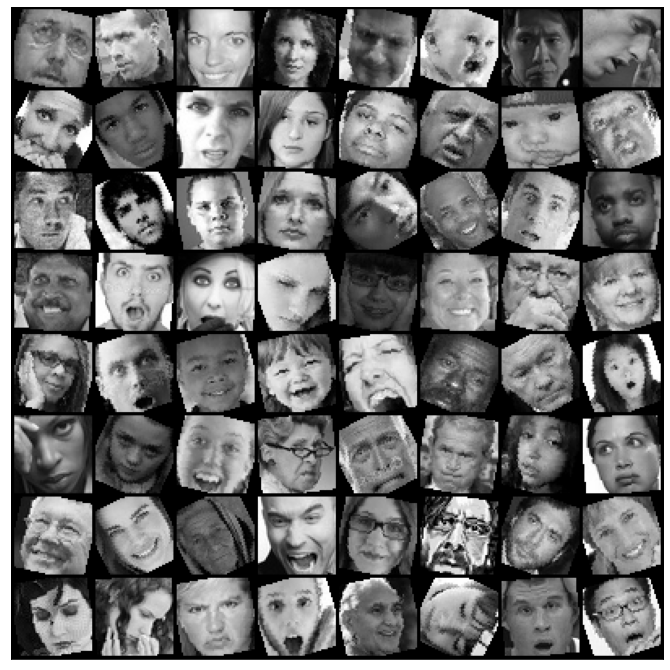

In [13]:
show_batch(train_dl)

# Using a GPU
### Transferring the model and data to the 'cuda', if available

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Training Steps Creation

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# Model Creation

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [19]:
model = to_device(ResNet(1, len(classes_train)), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

# Training the Model

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up Custom Optimizer with Weight Decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient Clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & Update Learning Rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.9403847455978394, 'val_acc': 0.11861111223697662}]

In [22]:
# Defining the parameters value for training
epochs = 24
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [23]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00068, train_loss: 2.0027, val_loss: 1.6927, val_acc: 0.3620
Epoch [1], last_lr: 0.00169, train_loss: 1.7285, val_loss: 1.6096, val_acc: 0.3762
Epoch [2], last_lr: 0.00316, train_loss: 1.7162, val_loss: 1.5697, val_acc: 0.3797
Epoch [3], last_lr: 0.00482, train_loss: 1.9024, val_loss: 1.7922, val_acc: 0.3526
Epoch [4], last_lr: 0.00636, train_loss: 1.9911, val_loss: 1.5906, val_acc: 0.3406
Epoch [5], last_lr: 0.00748, train_loss: 1.7808, val_loss: 1.6106, val_acc: 0.3822
Epoch [6], last_lr: 0.00799, train_loss: 1.6393, val_loss: 1.4739, val_acc: 0.4310
Epoch [7], last_lr: 0.00796, train_loss: 1.4780, val_loss: 1.4948, val_acc: 0.4345
Epoch [8], last_lr: 0.00778, train_loss: 1.3945, val_loss: 1.5605, val_acc: 0.3750
Epoch [9], last_lr: 0.00746, train_loss: 1.3496, val_loss: 1.4790, val_acc: 0.4451
Epoch [10], last_lr: 0.00703, train_loss: 1.3082, val_loss: 1.6268, val_acc: 0.4017
Epoch [11], last_lr: 0.00649, train_loss: 1.2824, val_loss: 1.4279, val_acc: 0.4428
Ep

# Plotting Performance Graphs of the Model

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize=(12,8))
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig('plots/accuracy_plot.png', bboxes_inches='tight')
    plt.show;

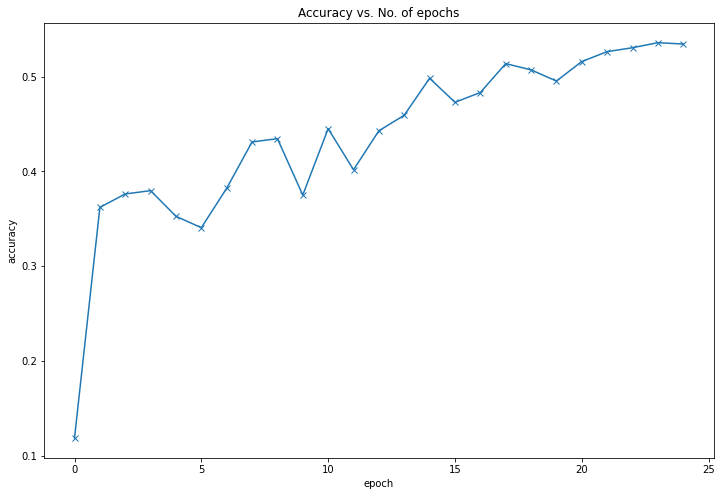

In [25]:
plot_accuracies(history)

In [26]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.figure(figsize=(12,8))
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.savefig('plots/lr_plot.png', bboxes_inches='tight')
    plt.show();

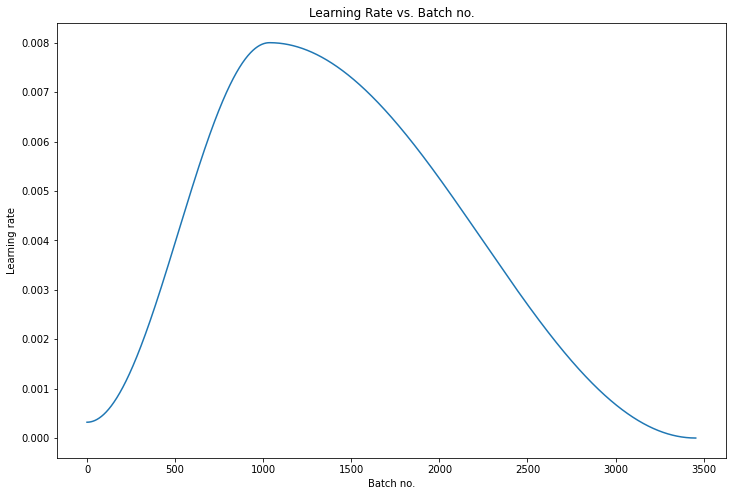

In [27]:
plot_lrs(history)

# Getting Predictions for the Validation Data

In [28]:
# UDF to get the predictions
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = []
    for batch in loader:
        image_batch, label_batch = batch
 
        tensor_batch = model(image_batch)
        all_preds.extend(tensor_batch.argmax(dim=1).tolist())
    return all_preds

In [29]:
valid_preds = get_all_preds(model, valid_dl)

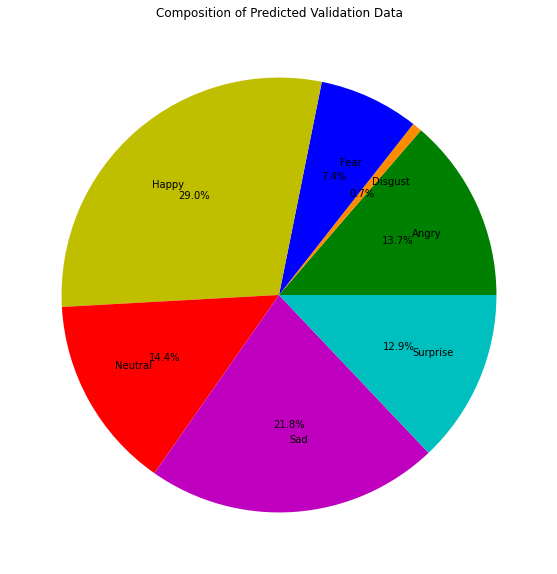

In [30]:
plt.subplots(figsize=(10,10))
plt.pie(pd.Series(valid_preds).value_counts().sort_index(), autopct='%0.1f%%', labels=classes, labeldistance=0.67, colors=['g','darkorange', 'b', 'y', 'r', 'm', 'c'])
plt.title('Composition of Predicted Validation Data')
plt.savefig('plots/valid_pred_composition.png', bboxes_inches='tight')
plt.show()

### Classification Report

In [31]:
print(classification_report(valid_ds.targets, valid_preds, target_names=classes))

              precision    recall  f1-score   support

       Angry       0.49      0.49      0.49       491
     Disgust       0.46      0.22      0.30        55
        Fear       0.45      0.23      0.30       528
       Happy       0.74      0.87      0.80       879
     Neutral       0.28      0.23      0.25       626
         Sad       0.42      0.56      0.48       594
    Surprise       0.65      0.72      0.68       416

    accuracy                           0.53      3589
   macro avg       0.50      0.47      0.47      3589
weighted avg       0.51      0.53      0.51      3589



### Confusion Matrix

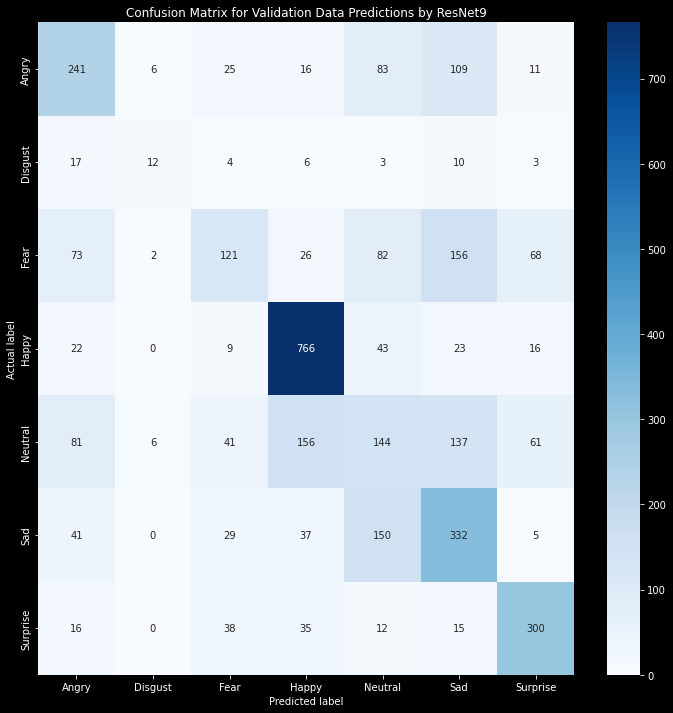

In [32]:
cm = confusion_matrix(valid_ds.targets, valid_preds, labels=[0,1,2,3,4,5,6])
with plt.style.context('dark_background'):
    plt.figure(figsize=(12,12))
    sns.heatmap(cm, annot=True,  fmt='d', xticklabels = classes, yticklabels = classes, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for Validation Data Predictions by ResNet9')
    plt.savefig('plots/Confusion_matrix.png', bboxes_inches='tight')
    plt.show()

# Saving the Model

In [33]:
torch.save(model.state_dict(), 'models/emotion_detection_model_state.pth')